In [9]:
import numpy as np
import sys
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

fs=14


from foggie.utils import consistency
cmap = consistency.temperature_discrete_cmap
c_all = plt.cm.Greys(0.7)
c_cold = cmap(0.05)
c_cool = cmap(0.25)
c_warm = cmap(0.6)
c_hot = cmap(0.9)

gc_ls = '-'
gc_lw = 3

sun_ls = ':'
sun_lw = 3

vmin = -400
vmax = 400

ymin1 = 2e3 #2e3, 2e3 # 2e3
ymax1 = 3e8 #3e7, 1e7 # 3e8

ymin2 = 0.001
ymax2 = 4 # 0.6, 0.4, 4 

In [10]:
sim_name = 'nref11n_nref10f'
dd_name = 'DD2175'
obj_tag = 'cgm-15kpc'
b_tag = 'highb'
b_lim = 20

In [2]:
def which_phase_to_plot(tag='cold'):
    
    if tag == 'all': 
        color = 'k' 
        dMdv_sun = dM_all_sun 
        dMdv_gc = dM_all_gc 
        dMdt_sun = dMdt_all_sun
        dMdt_gc = dMdt_all_gc
    elif tag == 'cold': 
        color = c_cold 
        dMdv_sun = dM_cold_sun 
        dMdv_gc = dM_cold_gc 
        dMdt_sun = dMdt_cold_sun
        dMdt_gc = dMdt_cold_gc
    elif tag == 'cool': 
        color = c_cool
        dMdv_sun = dM_cool_sun 
        dMdv_gc = dM_cool_gc 
        dMdt_sun = dMdt_cool_sun
        dMdt_gc = dMdt_cool_gc
    elif tag == 'warm': 
        color = c_warm 
        dMdv_sun = dM_warm_sun 
        dMdv_gc = dM_warm_gc 
        dMdt_sun = dMdt_warm_sun
        dMdt_gc = dMdt_warm_gc
    elif tag == 'hot': 
        color = c_hot
        dMdv_sun = dM_hot_sun 
        dMdv_gc = dM_hot_gc 
        dMdt_sun = dMdt_hot_sun
        dMdt_gc = dMdt_hot_gc
        
    return color, dMdv_sun, dMdv_gc, dMdt_sun, dMdt_gc 

def read_dMdv_file(filename, b_tag='allb'):
    if b_tag not in ['allb', 'lowb', 'highb']: 
        print("b_tag has to be all, lowb, or highb")
        sys.exit()
    # b_tag: all, lowb, highb
    
    # file_gc = 'figs/dM_dv/fits/nref11n_nref10f_DD2175_dMdv_%s_halo_center_%s.fits'%(obj_tag, shift)
    data = Table.read(filename, format='fits')
    dv_bins = data['v (km/s)']
    
    # print(data.keys())
    dM_all = data['dM_%s (Msun/km/s)'%(b_tag)]
    dM_cold = data['dM_cold_%s (Msun/km/s)'%(b_tag)]
    dM_cool = data['dM_cool_%s (Msun/km/s)'%(b_tag)]
    dM_warm = data['dM_warm_%s (Msun/km/s)'%(b_tag)]
    dM_hot = data['dM_hot_%s (Msun/km/s)'%(b_tag)]
        
    return dv_bins, dM_all, dM_cold, dM_cool, dM_warm, dM_hot 

def read_dMdt_file(filename, b_tag='allb'): 
    if b_tag not in ['allb', 'lowb', 'highb']: 
        print("b_tag has to be all, lowb, or highb")
        sys.exit()
    # b_tag: all, lowb, highb
    
    # file = 'figs/dM_dt/fits/nref11n_nref10f_DD2175_dMdt_%s_halo_center.fits'%(obj_tag)
    data = Table.read(filename, format='fits')
    dv_bins = data['v (km/s)']
    dMdt_all = data['dMdt_%s (Msun/yr)'%(b_tag)]
    dMdt_cold = data['dMdt_cold_%s (Msun/yr)'%(b_tag)]
    dMdt_cool = data['dMdt_cool_%s (Msun/yr)'%(b_tag)]
    dMdt_warm = data['dMdt_warm_%s (Msun/yr)'%(b_tag)]
    dMdt_hot = data['dMdt_hot_%s (Msun/yr)'%(b_tag)]
    
    # let's do a little tweak to the dMdt to make them all positive for better illustration 
    dMdt_all[dv_bins<=0] = np.abs(dMdt_all[dv_bins<=0])
    dMdt_cold[dv_bins<=0] = np.abs(dMdt_cold[dv_bins<=0])
    dMdt_cool[dv_bins<=0] = np.abs(dMdt_cool[dv_bins<=0])
    dMdt_warm[dv_bins<=0] = np.abs(dMdt_warm[dv_bins<=0])
    dMdt_hot[dv_bins<=0] = np.abs(dMdt_hot[dv_bins<=0])
    
    return dv_bins, dMdt_all, dMdt_cold, dMdt_cool, dMdt_warm, dMdt_hot

dMdv from halo center and from off center 

In [15]:
####################### get dM/dv from halo center ##########################
file_gc = 'figs/dM_dv/fits/nref11n_nref10f_DD2175_dMdv_%s_halo_center_b%d.fits'%(obj_tag, b_lim)
dMdv_gc = read_dMdv_file(file_gc, b_tag=b_tag)
dv_bins = dMdv_gc[0]
dMdv_all_gc = dMdv_gc[1]
dMdv_cold_gc = dMdv_gc[2]
dMdv_vcool_gc = dMdv_gc[3]
dMdv_warm_gc = dMdv_gc[4]
dMdv_hot_gc = dMdv_gc[5]

#### dM/dv from off center ###### 
dMdv_all_sun = np.zeros((8, dv_bins.size))
dMdv_cold_sun = np.zeros(dMdv_all_sun.shape)
dMdv_cool_sun = np.zeros(dMdv_all_sun.shape)
dMdv_warm_sun = np.zeros(dMdv_all_sun.shape)
dMdv_hot_sun = np.zeros(dMdv_all_sun.shape)

shifts = ['0', '45', '90', '135', '180', '225', '270', '315']
data_dir = 'figs/dM_dv/fits/'
for i, ideg in enumerate(shifts): 
    if i == 0: 
        file_sun = '%s/nref11n_nref10f_DD2175_dMdv_%s_offcenter_location_b%d.fits'%(data_dir, obj_tag, b_lim)
    else: 
        file_sun = '%s/nref11n_nref10f_DD2175_dMdv_%s_offcenter_location_b%d_%s.fits'%(data_dir, obj_tag, b_lim, ideg)
    dMdv_sun = read_dMdv_file(file_sun, b_tag=b_tag)
    # dv_bins_sun = dMdv_sun[0]
    dMdv_all_sun[i] = dMdv_sun[1]
    dMdv_cold_sun[i] = dMdv_sun[2]
    dMdv_cool_sun[i] = dMdv_sun[3]
    dMdv_warm_sun[i] = dMdv_sun[4]
    dMdv_hot_sun[i] = dMdv_sun[5]

dMdt from halo center and from off centers 

In [6]:
####################### get dM/dt ########################## 
file_gc = 'figs/dM_dt/fits/nref11n_nref10f_DD2175_dMdt_%s_halo_center.fits'%(obj_tag)
dMdt_gc = read_dMdt_file(file_gc, b_tag=b_tag)
dv_bins = dMdt_gc[0]
dMdt_all_gc = dMdt_gc[1]
dMdt_cold_gc = dMdt_gc[2]
dMdt_cool_gc = dMdt_gc[3]
dMdt_warm_gc = dMdt_gc[4]
dMdt_hot_gc = dMdt_gc[5]

##### get dM/dt wrt to observer ##### 
dMdt_all_sun = np.zeros((8, dv_bins.size))
dMdt_cold_sun = np.zeros(dMdt_all_sun.shape)
dMdt_cool_sun = np.zeros(dMdt_all_sun.shape)
dMdt_warm_sun = np.zeros(dMdt_all_sun.shape)
dMdt_hot_sun = np.zeros(dMdt_all_sun.shape)

shifts = ['0', '45', '90', '135', '180', '225', '270', '315']
data_dir = 'figs/dM_dt/fits'
for i, ideg in enumerate(shifts): 
    if i == 0: 
        file_sun = '%s/nref11n_nref10f_DD2175_dMdt_%s_offcenter_location.fits'%(data_dir, obj_tag)
    else: 
        file_sun = '%s/nref11n_nref10f_DD2175_dMdt_%s_offcenter_location_%s.fits'%(data_dir, obj_tag, ideg)
    dMdt_sun = read_dMdt_file(file_sun, b_tag=b_tag)
    # dv_bins_sun = dMdt_sun[0]
    dMdt_all_sun[i] = dMdt_sun[1]
    dMdt_cold_sun[i] = dMdt_sun[2]
    dMdt_cool_sun[i] = dMdt_sun[3]
    dMdt_warm_sun[i] = dMdt_sun[4]
    dMdt_hot_sun[i] = dMdt_sun[5]

KeyError: 'dMdt_highb (Msun/yr)'

Calculate the flux rate dM/dt for low/high velocity inflowing and outflowing gases 

In [17]:
for i, phase_tag in enumerate(['all', 'cold', 'cool', 'warm', 'hot']): 
    # color, dMdv_sun, dMdv_gc, dMdt_sun, dMdt_gc 
    this_phase = which_phase_to_plot(tag=phase_tag)
    dMdt_sun = this_phase[3]
    dMdt_gc = this_phase[4]
    vel = dv_bins
    
    ############################################################################ 
    dMdt_sun_mean = np.mean(dMdt_sun, axis=0)
    dMdt_sun_min = np.min(dMdt_sun, axis=0)
    dMdt_sun_max = np.max(dMdt_sun, axis=0)
    
    in_high = vel<-100
    in_low = np.all([vel>=-100, vel<=0], axis=0)
    out_high = vel>100 
    out_low = np.all([vel>0, vel<=100], axis=0)

    f_in_high = dMdt_sun_mean[in_high].sum()
    f_in_low = dMdt_sun_mean[in_low].sum()
    f_out_high = dMdt_sun_mean[out_high].sum()
    f_out_low = dMdt_sun_mean[out_low].sum()
    
    print('dM/dt', phase_tag)
    print('in_high: %.2f, in_low: %.2f, out_high: %.2f, out_low: %.2f'%(f_in_high, f_in_low, f_out_high, f_out_low))

NameError: name 'dM_all_sun' is not defined

plot the dMdv and dMdt for different phases together 

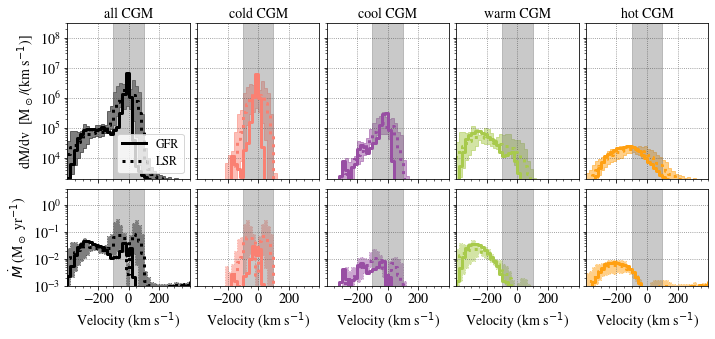

In [13]:
fig = plt.figure(figsize=(10, 4.5))
width = 0.17
gap = 0.01

for i, phase_tag in enumerate(['all', 'cold', 'cool', 'warm', 'hot']): 
    ##### get data #### 
    # now decide which phase to plot things on ### 
    # phase_tag = 'cold'
    this_phase = which_phase_to_plot(tag=phase_tag)
    color = this_phase[0]
    dMdv_sun = this_phase[1]
    dMdv_gc = this_phase[2]
    dMdt_sun = this_phase[3]
    dMdt_gc = this_phase[4]
    vel = dv_bins

    # find the range of the variation and the median value of the total eight location 
    dMdv_sun_mean = np.mean(dMdv_sun, axis=0)
    dMdv_sun_min = np.min(dMdv_sun, axis=0)
    dMdv_sun_max = np.max(dMdv_sun, axis=0)
    
    ############################################################################ 
    dMdt_sun_mean = np.mean(dMdt_sun, axis=0)
    dMdt_sun_min = np.min(dMdt_sun, axis=0)
    dMdt_sun_max = np.max(dMdt_sun, axis=0)
    
    ###################################################################
    #ax1 = fig.add_axes([0.08+width*i, 0.5, width, 0.45])
    #ax2 = fig.add_axes([0.08+width*i, 0.1, width, 0.38])
    ax1 = fig.add_axes([0.09+i*(width+gap), 0.46, width, 0.48])
    ax2 = fig.add_axes([0.09+i*(width+gap), 0.13, width, 0.30])
    # fig_tag = all_tags[i]
    
    ### plot 
    ax1.step(vel, dMdv_gc, color=color, linestyle=gc_ls, linewidth=gc_lw, label='GFR')
    ax1.step(vel, dMdv_sun_mean, color=color, linestyle=sun_ls, linewidth=sun_lw, label='LSR')
    ax1.fill_between(vel, dMdv_sun_min, dMdv_sun_max, step="pre", alpha=0.5, color=color)

    ax1.set_yscale('log')
    ax1.set_xlim(vmin, vmax)
    ax1.set_xticklabels([])
    ax1.set_ylim(ymin1, ymax1)
    ax1.minorticks_on()
    if i == 0: 
        ax1.legend(fontsize=fs-2, loc='lower right')
    ax1.fill_between([-100, 100], ymin1, ymax1, color=plt.cm.Greys(0.6), alpha=0.4)
    # ax1.text(200, 1e8, fig_tag, fontsize=fs-2)
    ax1.set_title(r'%s CGM'%(phase_tag), fontsize=fs)

    # for the infall rate test 
    ax2.step(vel, dMdt_gc, color=color, linestyle=gc_ls, linewidth=gc_lw, label='wrt gc')
    ax2.step(vel, dMdt_sun_mean, color=color, linestyle=sun_ls, linewidth=sun_lw, label='wrt sun')
    ax2.fill_between(vel, dMdt_sun_min, dMdt_sun_max, color=color, linestyle=sun_ls, step="pre", alpha=0.5)
    # ax2.legend(fontsize=fs-2, loc='upper right')

    ax2.set_ylim(ymin2, ymax2)
    ax2.set_yscale('log')
    ax2.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=fs)
    ax2.fill_between([-100, 100], ymin2, ymax2, color=plt.cm.Greys(0.6), alpha=0.4)
    
    for ax in [ax1, ax2]: 
        ax.minorticks_on()
        ax.set_xlim(vmin, vmax)
        ax.grid(linestyle=':', alpha=0.7, color=plt.cm.Greys(0.8))
        ax.set_xticks([-200, 0, 200])
        for tick in ax.xaxis.get_major_ticks(): 
            tick.label.set_fontsize(fs)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(fs)
        
    # only need this for the first column 
    if phase_tag == 'all': 
        ax1.set_ylabel(r'dM/dv  [M$_\odot$/(km s$^{-1}$)]', fontsize=fs)
        ax2.set_ylabel(r'$\dot{M}$ (M$_\odot$ yr$^{-1}$)', fontsize=fs)
    else: 
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])

# fig.savefig('figs/dM_dt/nref11n_nref10f_DD2175_dMdv_dMdt_%s_allphases_%s.pdf'%(obj_tag, b_tag))
# fig.savefig('/Users/Yong/Desktop/save.pdf')

Only plot the dMdv for different phases 

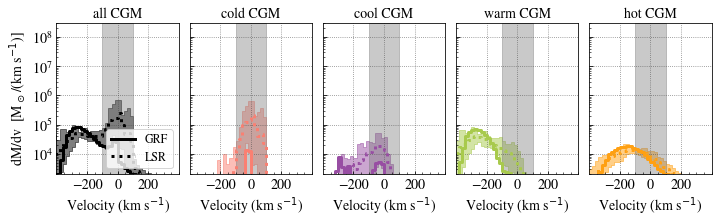

In [35]:
fig = plt.figure(figsize=(10, 3.))
width = 0.17
gap = 0.015

for i, phase_tag in enumerate(['all', 'cold', 'cool', 'warm', 'hot']): 
    ##### get data #### 
    # now decide which phase to plot things on ### 
    # phase_tag = 'cold'
    this_phase = which_phase_to_plot(tag=phase_tag)
    color = this_phase[0]
    dMdv_sun = this_phase[1]
    dMdv_gc = this_phase[2]
    dMdt_sun = this_phase[3]
    dMdt_gc = this_phase[4]
    vel = dv_bins

    # find the range of the variation and the median value of the total eight location 
    dMdv_sun_mean = np.mean(dMdv_sun, axis=0)
    dMdv_sun_min = np.min(dMdv_sun, axis=0)
    dMdv_sun_max = np.max(dMdv_sun, axis=0)
    
    ###################################################################
    #ax1 = fig.add_axes([0.08+width*i, 0.5, width, 0.45])
    #ax2 = fig.add_axes([0.08+width*i, 0.1, width, 0.38])
    ax1 = fig.add_axes([0.07+i*(width+gap), 0.2, width, 0.7])
    # fig_tag = all_tags[i]
    
    ### plot 
    ax1.step(vel, dMdv_gc, color=color, linestyle=gc_ls, linewidth=gc_lw, label='GRF')
    ax1.step(vel, dMdv_sun_mean, color=color, linestyle=sun_ls, linewidth=sun_lw, label='LSR')
    ax1.fill_between(vel, dMdv_sun_min, dMdv_sun_max, step="pre", alpha=0.5, color=color)

    ax1.set_yscale('log')
    ax1.set_xlim(vmin, vmax)
    ax1.set_ylim(ymin1, ymax1)
    ax1.minorticks_on()
    if i == 0: 
        ax1.legend(fontsize=fs-2, loc='lower right')
    ax1.fill_between([-100, 100], ymin1, ymax1, color=plt.cm.Greys(0.6), alpha=0.4)
    ax1.set_title(r'%s CGM'%(phase_tag), fontsize=fs)

    ax1.minorticks_on()
    ax1.set_xlim(vmin, vmax)
    ax1.grid(linestyle=':', alpha=0.7, color=plt.cm.Greys(0.8))
    ax1.set_xticks([-200, 0, 200])
    for tick in ax1.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(fs)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(fs)
    ax1.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=fs)
    
    ax1.tick_params(direction='in', which='both') 
        
    # only need this for the first column 
    if phase_tag == 'all': 
        ax1.set_ylabel(r'dM/dv  [M$_\odot$/(km s$^{-1}$)]', fontsize=fs)
    else: 
        ax1.set_yticklabels([])

# fig.savefig('figs/dM_dt/nref11n_nref10f_DD2175_dMdv_%s_allphases_%s.pdf'%(obj_tag, b_tag))
# fig.savefig('/Users/Yong/Desktop/save.pdf')

### II: Find masses at the high velocity regimes, and here high-velocity is defined as |vlsr|>100 km/s

In [15]:
from astropy.table import Table 
import numpy as np

sim_name = 'nref11n_nref10f'
dd_name = 'DD2175'
obj_tag = 'cgm-rvir'# 'cgm-rvir'# 'cgm-15kpc'

In [16]:
for i in range(8): 
    if i == 0:
        # get dM/dv wrt to observer 
        file_sun = 'figs/dM_dv/fits/nref11n_nref10f_DD2175_dMdv_%s_offcenter_location.fits'%(obj_tag)
    else: 
        file_sun = 'figs/dM_dv/fits/nref11n_nref10f_DD2175_dMdv_%s_offcenter_location_%d.fits'%(obj_tag, i*45)
    data_sun = Table.read(file_sun, format='fits')
    dv_bins_sun = data_sun['v (km/s)']
    dM_all_sun = data_sun['dM (Msun/km/s)']
    dM_cold_sun = data_sun['dM_cold (Msun/km/s)']
    dM_cool_sun = data_sun['dM_cool (Msun/km/s)']
    dM_warm_sun = data_sun['dM_warm (Msun/km/s)']
    dM_hot_sun = data_sun['dM_hot (Msun/km/s)']

    # cold, cool, warm, hot gas components at the high-velocity ranges 
    ind_high = np.any([dv_bins_sun<=-100, dv_bins_sun>=100], axis=0)
    cold_high_mass = (dM_cold_sun[ind_high]*20).sum()
    cool_high_mass = (dM_cool_sun[ind_high]*20).sum()
    warm_high_mass = (dM_warm_sun[ind_high]*20).sum()
    hot_high_mass = (dM_hot_sun[ind_high]*20).sum()

    # cold, cool, warm, hot gas at the low-velocity ranges 
    ind_low = np.all([dv_bins_sun>-100, dv_bins_sun<100], axis=0)
    cold_low_mass = (dM_cold_sun[ind_low]*20).sum()
    cool_low_mass = (dM_cool_sun[ind_low]*20).sum()
    warm_low_mass = (dM_warm_sun[ind_low]*20).sum()
    hot_low_mass = (dM_hot_sun[ind_low]*20).sum()

    cold_all_mass = (dM_cold_sun*20).sum()
    cool_all_mass = (dM_cool_sun*20).sum()
    warm_all_mass = (dM_warm_sun*20).sum()
    hot_all_mass = (dM_hot_sun*20).sum()
    
    all_high_mass = cold_high_mass + cool_high_mass + warm_high_mass + hot_high_mass
    all_all_mass = (dM_all_sun*20).sum()

    print('cold, cool, warm, hot HVC: %.1e, %.1e, %.1e, %.1e'%(cold_high_mass, cool_high_mass, 
                                                               warm_high_mass, hot_high_mass))
    print('cold, cool, warm, hot LVC: %.1e, %.1e, %.1e, %.1e'%(cold_low_mass, cool_low_mass, 
                                                               warm_low_mass, hot_low_mass))
    print('high/all frac: %.2f, %.2f, %.2f, %.2f, %.2f\n'%(cold_high_mass/cold_all_mass, 
                                                         cool_high_mass/cool_all_mass, 
                                                         warm_high_mass/warm_all_mass, 
                                                         hot_high_mass/hot_all_mass, 
                                                         all_high_mass/all_all_mass))

cold, cool, warm, hot HVC: 1.2e+09, 1.2e+09, 2.1e+09, 7.1e+07
cold, cool, warm, hot LVC: 3.5e+09, 9.0e+08, 2.4e+09, 5.4e+07
high/all frac: 0.25, 0.56, 0.46, 0.57, 0.39

cold, cool, warm, hot HVC: 1.5e+07, 9.8e+08, 1.9e+09, 7.9e+07
cold, cool, warm, hot LVC: 4.7e+09, 1.1e+09, 2.6e+09, 4.6e+07
high/all frac: 0.00, 0.48, 0.42, 0.63, 0.26

cold, cool, warm, hot HVC: 2.4e+07, 1.2e+09, 1.4e+09, 6.7e+07
cold, cool, warm, hot LVC: 4.7e+09, 8.8e+08, 3.1e+09, 5.8e+07
high/all frac: 0.01, 0.57, 0.32, 0.54, 0.24

cold, cool, warm, hot HVC: 1.2e+09, 1.2e+09, 2.2e+09, 8.9e+07
cold, cool, warm, hot LVC: 3.5e+09, 8.3e+08, 2.3e+09, 3.7e+07
high/all frac: 0.25, 0.60, 0.48, 0.71, 0.41

cold, cool, warm, hot HVC: 1.9e+08, 1.4e+09, 2.0e+09, 7.7e+07
cold, cool, warm, hot LVC: 4.5e+09, 7.0e+08, 2.5e+09, 4.8e+07
high/all frac: 0.04, 0.66, 0.44, 0.62, 0.31

cold, cool, warm, hot HVC: 4.7e+08, 1.2e+09, 2.4e+09, 7.1e+07
cold, cool, warm, hot LVC: 4.2e+09, 8.6e+08, 2.1e+09, 5.4e+07
high/all frac: 0.10, 0.58, 0.54

In [3]:
cold_hvc_frac = [0.25, 0, 0.01, 0.25, 0.04, 0.10, 0.42, 0.17]
cool_hvc_frac = [0.56, 0.48, 0.57, 0.60, 0.66, 0.58, 0.64, 0.60]
warm_hvc_frac = [0.46, 0.42, 0.32, 0.48, 0.44, 0.54, 0.58, 0.47]
hot_hvc_frac = [0.57, 0.63, 0.54, 0.71, 0.62, 0.57, 0.58, 0.54]
all_hvc_frac = [0.39, 0.26, 0.24, 0.41, 0.31, 0.37, 0.53, 0.37]

In [4]:
np.mean(cold_hvc_frac), np.mean(cool_hvc_frac), np.mean(warm_hvc_frac), np.mean(hot_hvc_frac), np.mean(all_hvc_frac)

(0.155, 0.5862499999999999, 0.46375, 0.595, 0.36)

### III: calculate the mass flux rate dMdt for gas in different phases, and averaged over 8 locations 

In [40]:
sim_name = 'nref11n_nref10f'
dd_name = 'DD2175'
obj_tag = 'cgm-15kpc' # 'cgm-15kpc'# 'cgm-rvir'

In [41]:
## for gc values 
file_gc = 'figs/dM_dt/fits/nref11n_nref10f_DD2175_dMdt_%s_halo_center.fits'%(obj_tag)
vel, dMdt_all_gc, dMdt_cold_gc, dMdt_cool_gc, dMdt_warm_gc, dMdt_hot_gc = read_dMdt_file(file_gc)

# first, do inflow velocity rate 
indv_in = vel < 0
cold_in_gc = -dMdt_cold_gc[indv_in].sum()
cool_in_gc = -dMdt_cool_gc[indv_in].sum()
warm_in_gc = -dMdt_warm_gc[indv_in].sum()
hot_in_gc = -dMdt_hot_gc[indv_in].sum()

# then do outflow velocity rate 
indv_out = vel>0 
cold_out_gc = dMdt_cold_gc[indv_out].sum()
cool_out_gc = dMdt_cool_gc[indv_out].sum()
warm_out_gc = dMdt_warm_gc[indv_out].sum()
hot_out_gc = dMdt_hot_gc[indv_out].sum()

In [42]:
## for value wrt sun 
cold_in_sun, cool_in_sun, warm_in_sun, hot_in_sun = [], [], [], []
cold_out_sun, cool_out_sun, warm_out_sun, hot_out_sun = [], [], [], []

for i in range(8): 
    # get dM/dt, wrt gc 
    if i == 0: 
        file_sun = 'figs/dM_dt/fits/nref11n_nref10f_DD2175_dMdt_%s_offcenter_location.fits'%(obj_tag)
    else: 
        file_sun = 'figs/dM_dt/fits/nref11n_nref10f_DD2175_dMdt_%s_offcenter_location_%d.fits'%(obj_tag, i*45)
        
    vel, dMdt_all_sun, dMdt_cold_sun, dMdt_cool_sun, dMdt_warm_sun, dMdt_hot_sun = read_dMdt_file(file_sun)
    
    # first, do inflow velocity rate 
    indv_in = vel < 0
    cold_in_sun.append(-dMdt_cold_sun[indv_in].sum())
    cool_in_sun.append(-dMdt_cool_sun[indv_in].sum())
    warm_in_sun.append(-dMdt_warm_sun[indv_in].sum())
    hot_in_sun.append(-dMdt_hot_sun[indv_in].sum())

    # then do outflow velocity rate 
    indv_out = vel>0 
    cold_out_sun.append(dMdt_cold_sun[indv_out].sum())
    cool_out_sun.append(dMdt_cool_sun[indv_out].sum())
    warm_out_sun.append(dMdt_warm_sun[indv_out].sum())
    hot_out_sun.append(dMdt_hot_sun[indv_out].sum())

In [43]:
from foggie.utils import consistency
cmap = consistency.temperature_discrete_cmap
c_cold = cmap(0.05)
c_cool = cmap(0.25)
c_warm = cmap(0.6)
c_hot = cmap(0.9)
colors=[c_cold, c_cool, c_warm, c_hot]
gray = plt.cm.Greys(0.8)

In [44]:
gc_color = plt.cm.Greys(0.6)
sun_color = plt.cm.Oranges(0.5)
fs = 12

In [45]:
labels = ['cold', 'cool', 'warm', 'hot']
in_gc = [cold_in_gc, cool_in_gc, warm_in_gc, hot_in_gc]
in_sun = [np.mean(cold_in_sun), np.mean(cool_in_sun), np.mean(warm_in_sun), np.mean(hot_in_sun)]
in_sun_min = [np.min(cold_in_sun), np.min(cool_in_sun), np.min(warm_in_sun), np.min(hot_in_sun)]
in_sun_max = [np.max(cold_in_sun), np.max(cool_in_sun), np.max(warm_in_sun), np.max(hot_in_sun)]
in_sun_std = [np.std(cold_in_sun), np.std(cool_in_sun), np.std(warm_in_sun), np.std(hot_in_sun)]

out_gc = [cold_out_gc, cool_out_gc, warm_out_gc, hot_out_gc]
out_sun = [np.mean(cold_out_sun), np.mean(cool_out_sun), np.mean(warm_out_sun), np.mean(hot_out_sun)]
out_sun_min = [np.min(cold_out_sun), np.min(cool_out_sun), np.min(warm_out_sun), np.min(hot_out_sun)]
out_sun_max = [np.max(cold_out_sun), np.max(cool_out_sun), np.max(warm_out_sun), np.max(hot_out_sun)]
out_sun_std = [np.std(cold_out_sun), np.std(cool_out_sun), np.std(warm_out_sun), np.std(hot_out_sun)]

In [46]:
print(obj_tag)
for i in range(4):
    a = in_gc[i]+out_gc[i]
    b = in_sun[i]+out_sun[i]
    c = b/a
    d = in_sun[i]/in_gc[i]
    e = out_sun[i]/out_gc[i]
    print('%4s: %.2f, %.2f, ratio=%.1f (all), %.1f (in), %.1f (in)'%(labels[i], a, b, c, d, e))

cgm-15kpc
cold: -0.03, -0.00, ratio=0.1 (all), 4.9 (in), 10.1 (in)
cool: -0.06, -0.05, ratio=0.9 (all), 1.2 (in), 7.6 (in)
warm: -0.27, -0.25, ratio=0.9 (all), 0.9 (in), 0.8 (in)
 hot: -0.01, -0.03, ratio=2.0 (all), 0.9 (in), 0.6 (in)


In [49]:
in_gc[1], in_sun[1]

(-0.061566451101893405, -0.07284871649084987)

In [47]:
print(obj_tag)
for i in range(4):
    a = in_gc[i]+out_gc[i]
    b = in_sun[i]+out_sun[i]
    c = b/a
    d = in_sun[i]/in_gc[i]
    e = out_sun[i]/out_gc[i]
    print('%4s: %.2f, %.2f, ratio=%.1f (all), %.1f (in), %.1f (in)'%(labels[i], a, b, c, d, e))

cgm-15kpc
cold: -0.03, -0.00, ratio=0.1 (all), 4.9 (in), 10.1 (in)
cool: -0.06, -0.05, ratio=0.9 (all), 1.2 (in), 7.6 (in)
warm: -0.27, -0.25, ratio=0.9 (all), 0.9 (in), 0.8 (in)
 hot: -0.01, -0.03, ratio=2.0 (all), 0.9 (in), 0.6 (in)


In [ ]:
print(obj_tag)
for i in range(4):
    a = in_sun[i]/in_gc[i]
    b = out_sun[i]/
    print('%4s: %.2f, %.2f, ratio=%.1f'%(labels[i], a, b, c))

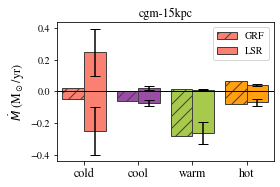

In [29]:
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(4, 2.7))
barlist1 = ax.bar(x - width/2, in_gc, width, label='GRF', 
                  color=colors, hatch='//', edgecolor=gray)
barlist2 = ax.bar(x - width/2, out_gc, width, label=None, 
                  color=colors, hatch='//', edgecolor=gray)

barlist3 = ax.bar(x + width/2, in_sun, width, label='LSR', 
                  color=colors, edgecolor=gray, yerr=in_sun_std, ecolor='black', capsize=5)
barlist4 = ax.bar(x + width/2, out_sun, width, label=None, 
                  color=colors, edgecolor=gray, yerr=out_sun_std, ecolor='black', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\dot{M}$ (M$_\odot$/yr)', fontsize=fs)
ax.set_title(obj_tag, fontsize=fs)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=fs-2)

xmin = -0.5
xmax = len(labels)-0.5
ax.set_xlim(xmin, xmax)
# ax.set_yscale('symlog')
ax.hlines(0, xmin, xmax, linestyle='-', lw=1)
# ax.minorticks_on()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fs)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fs-2)
fig.tight_layout()

plt.show()
fig.savefig('figs/dM_dt/flux_grf_lsr_hist_%s.pdf'%(obj_tag))